# Pre processing for skin lesion dataset

In [10]:
import cv2
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [ ]:
# Visualização auxiliar
def show_images(img_list, titles=None, cmap='gray'):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(img_list):
        plt.subplot(1, len(img_list), i+1)
        plt.imshow(img, cmap=cmap)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Etapa 1: Redimensionamento
class Resize(BaseEstimator, TransformerMixin):
    def __init__(self, size=(128, 128)):
        self.size = size
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [cv2.resize(img, self.size) for img in X]

# Etapa 2: Filtro Gaussiano (remoção de ruído)
class GaussianBlur(BaseEstimator, TransformerMixin):
    def __init__(self, ksize=(5, 5), sigma=0):
        self.ksize = ksize
        self.sigma = sigma

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [cv2.GaussianBlur(img, self.ksize, self.sigma) for img in X]

# Etapa 3: CLAHE (Equalização de histograma adaptativa)
class CLAHE(BaseEstimator, TransformerMixin):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.clahe.apply(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in X]

# Etapa 4: Segmentação simples usando Otsu
class OtsuThreshold(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binarized = []
        for img in X:
            _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            binarized.append(binary)
        return binarized


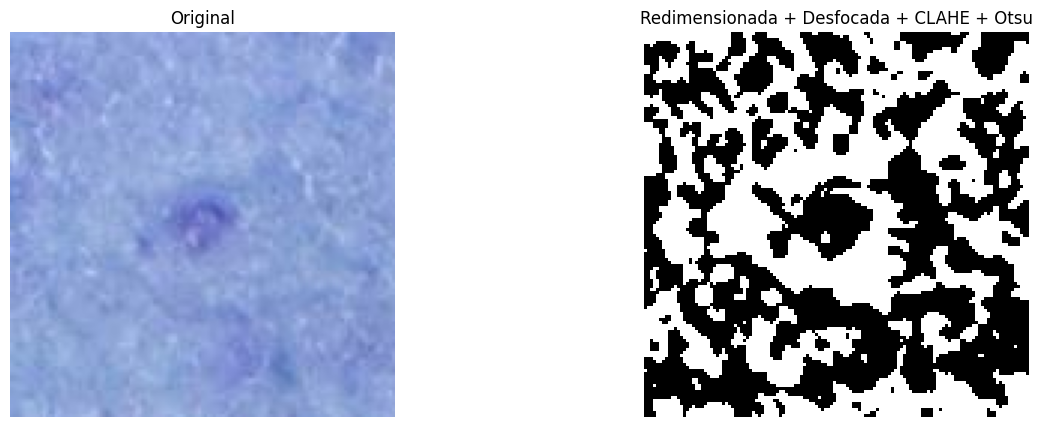

In [ ]:

# # Leitura da imagem de exemplo
# img_path = '../data/03_primary/ISIC_0052003.jpg'  # ou o caminho local da sua imagem
# original = cv2.imread(img_path)

# # Criando pipeline
# pipeline = Pipeline([
#     ('resize', Resize((128, 128))),
#     ('blur', GaussianBlur((5, 5))),
#     ('clahe', CLAHE()),
#     ('threshold', OtsuThreshold())
# ])

# # Aplicar pipeline
# processed_images = pipeline.fit_transform([original])

# # Visualização
# show_images(
#     [original, *processed_images],
#     titles=["Original", "Redimensionada + Desfocada + CLAHE + Otsu"]
# )

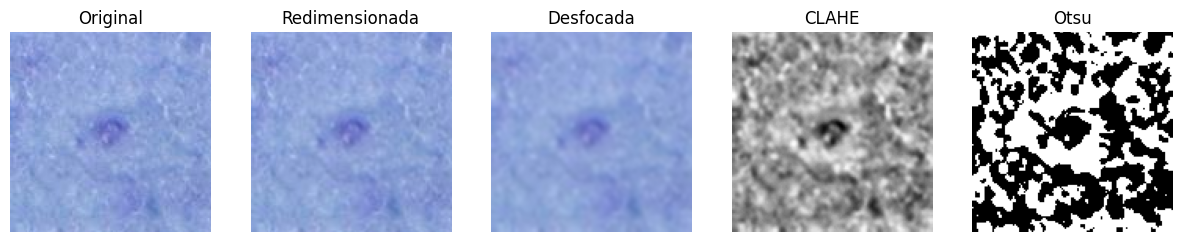

In [4]:
# Leitura da imagem de exemplo
img_path = '../data/03_primary/ISIC_0052003.jpg'  # ou o caminho local da sua imagem
original = cv2.imread(img_path)

step1 = Resize((128, 128)).fit_transform([original])
step2 = GaussianBlur((5, 5)).fit_transform(step1)
step3 = CLAHE().fit_transform(step2)
step4 = OtsuThreshold().fit_transform(step3)

show_images([original, step1[0], step2[0], step3[0], step4[0]],
            titles=["Original", "Redimensionada", "Desfocada", "CLAHE", "Otsu"])

##  Comprovar se houve melhora ou piora com determinada técnica

In [11]:
y_true = pd.read_csv('../data/03_primary/ISIC_2024/label.csv')
#y_true = y_true.iloc[:, 1].values
y_true[y_true.malignant == 1]

,isic_id,malignant
387,ISIC_0082829,1.0
935,ISIC_0096034,1.0
1245,ISIC_0104229,1.0
1846,ISIC_0119495,1.0
3478,ISIC_0157834,1.0
...,...,...
396165,ISIC_9877311,1.0
398671,ISIC_9941636,1.0
399936,ISIC_9972649,1.0
399943,ISIC_9972877,1.0


In [ ]:
# ---------- Dataset fictício (substitua pelo seu loader) ----------
base_path = r'../data/03_primary/ISIC_2024'
image_folder = os.path.join(base_path, 'images')
csv_path = os.path.join(base_path, 'label.csv')

# Lendo o CSV
df = pd.read_csv(csv_path)

# Função para carregar uma imagem
def load_image(filename, target_size=(128, 128)):
    img_path = os.path.join(image_folder, filename)
    img = cv2.imread(img_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    return img

# Carregando imagens e labels
images = []
labels = []

for _, row in df.iterrows():
    img = load_image(row['isic_id'])
    if img is not None:
        images.append(img)
        labels.append(row['label'])

X = np.array(images)
y = np.array(labels)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Converte os rótulos em one-hot encoding (se necessário)
num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # ou 'sigmoid' se for binário
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
              metrics=['accuracy'])

model.summary()


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


In [ ]:

# Filtrando apenas duas classes para classificação binária (ex: 0 e 1)
mask = (y.flatten() == 0) | (y.flatten() == 1)
X = X[mask]
y = y[mask]
y = y.flatten()

# ---------- Pipeline de pré-processamento ----------
preprocess_pipeline = Pipeline([
    ('resize', Resize((64, 64))),
    ('blur', GaussianBlur()),
    ('clahe', CLAHE())
])

X_processed = preprocess_pipeline.fit_transform(X)
X_processed = np.array(X_processed) / 255.0  # normalizando

# ---------- Train/Test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# ---------- Modelo simples com TensorFlow ----------
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, validation_split=0.1)

# ---------- Avaliação ----------
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))